---
# **Preparation**
---

In [1]:
# System Libraries
from dataclasses import dataclass
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

---
# **TensorFlow / Keras Use Cases**
---

**TensorFlow:**
|  Concept | Description  |
|---|---|
| Static Computation Graphs  | Calculate gradient of a variable using automatic differentation |
|  Runtimes |  TensorFlow can be run in C++, JavaScript, and mobile devices (TensorFlow Lite)| 
|  TensorFlow Serving | Production deployment  |
|  TF-Agents | Reinforcement Learning  |
|  TensorFlow Hub | Pretrained models  |
|  TFX | Industrial Machine Learning  |

--    

|  Use Case | Description  |
|---|---|
| Variable creation| tf.Variable |
| Mathematical Transformations| tf.matmul |
| Backpropagation | tf.GradientTape |

**Keras:**

|  Use Case | Description  |
|---|---|
| Layers| tf.keras.layers |
| Loss Functions| tf.keras.losses.sparse_categorical_crossentropy |
| Metrics | accuracy |
| Optimizer | tf.keras.optimizers.SGD |

---
# **Tensor Variable and Constant**
---

In [2]:
# Constant
tf.zeros(shape=(2, 1))
tf.ones(shape=(2, 2))
tf.random.uniform(shape=(2, 2), minval=0, maxval=1e-3)
tf.random.normal(shape=(2, 2), mean=0.0, stddev=1.0)

# Variable
tf_var1 = tf.Variable(initial_value=tf.ones(shape=(2, 2)))
tf_var2 = tf.Variable(initial_value=tf.random.uniform(shape=(2, 2)))

# Assign
tf_var1[1, 1].assign(3)

# Math operations
tf.square(tf_var1)  # Square
tf.sqrt(tf_var1)  # Square root

tf_var1 + tf_var2  # Add (Elementwise)
tf_var1.assign_add(tf_var2)  # tf_var1 += tf_var2

tf_var1 * tf_var1  # Multiply (Elementwise)
tf.matmul(tf_var1, tf_var1)  # Multiply (Dot Product)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 3.377597,  7.242276],
       [ 5.583919, 12.725226]], dtype=float32)>

---
# **1st Order Gradient**
---

In [3]:
input_const = tf.constant(value=3.0)
with tf.GradientTape() as tape:
    tape.watch(input_const)
    result = tf.square(input_const)
gradient = tape.gradient(result, input_const)

print(input_const)
print(input_const.numpy())
print(result)
print(gradient)

tf.Tensor(3.0, shape=(), dtype=float32)
3.0
tf.Tensor(9.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


---
# **2nd Order Gradient**
---

In [4]:
time = tf.Variable(initial_value=5.0)
with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape:
        position = (1 / 2.0) * (39.78) * (time**2)  # 1/2 * a * t2
    velocity = inner_tape.gradient(position, time)  # a * t
acceleration = outer_tape.gradient(velocity, time)  # a

print(position)
print(velocity)
print(acceleration)

tf.Tensor(497.25, shape=(), dtype=float32)
tf.Tensor(198.9, shape=(), dtype=float32)
tf.Tensor(39.78, shape=(), dtype=float32)


---
# **Dataset**
---

**Dataset**

In [5]:
@dataclass
class Constant:
    input_dim = 2
    output_dim = 1
    epoch = 500
    n = 0.1


class Dataset:
    def __init__(self):
        self.dataset()

    def dataset(self):
        n_samples = 1000

        # ---------------------------------------------------------------

        pos_samples = np.random.multivariate_normal(
            mean=[3, 0], cov=[[1.0, 0.5], [0.5, 1.0]], size=n_samples
        )
        neg_samples = np.random.multivariate_normal(
            mean=[0, 3], cov=[[1.0, 0.5], [0.5, 1.0]], size=n_samples
        )
        pos_targets = np.ones(shape=(n_samples, 1))
        neg_targets = np.zeros(shape=(n_samples, 1))

        pos_test_samples = np.array([[4, 0], [5, -2], [2, -1]]).astype(np.float32)
        neg_test_samples = np.array([[0, 2], [1, 4], [2, 4]]).astype(np.float32)

        samples = np.vstack(tup=(pos_samples, neg_samples)).astype(np.float32)
        targets = np.vstack(tup=(pos_targets, neg_targets)).astype(np.float32)

        # ---------------------------------------------------------------

        shuffle_indices = np.random.permutation(len(samples))
        shuffle_samples = samples[shuffle_indices]
        shuffle_targets = targets[shuffle_indices]

        # ---------------------------------------------------------------

        n_val = int(0.3 * len(shuffle_indices))

        self.train_samples = shuffle_samples[n_val:]
        self.train_targets = shuffle_targets[n_val:]

        self.val_samples = shuffle_samples[:n_val]
        self.val_targets = shuffle_targets[:n_val]

        self.test_samples = np.vstack(tup=(pos_test_samples, neg_test_samples)).astype(
            np.float32
        )

    def explore(self):
        plt.scatter(x=self.train_samples[:, 0], y=self.train_samples[:, 1])
        plt.scatter(x=self.val_samples[:, 0], y=self.val_samples[:, 1])


constant = Constant()
dataset = Dataset()

**Exploration**

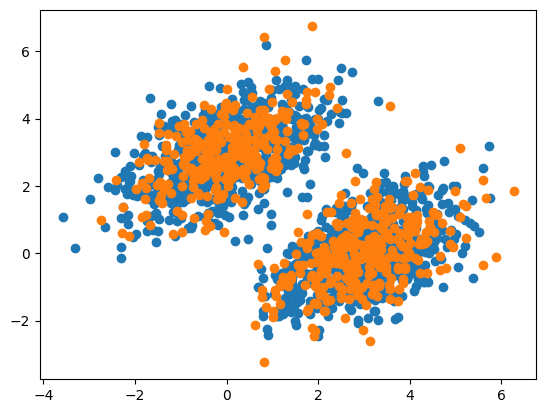

In [6]:
dataset.explore()

---
# **Linear Classifier — TensorFlow**
---

**Implementation**

In [7]:
class LinearClassifierTensorFlow:
    def __init__(self, n):
        self.w = tf.Variable(
            initial_value=tf.random.uniform(
                shape=(constant.input_dim, constant.output_dim)
            )
        )
        self.b = tf.Variable(initial_value=tf.zeros(shape=(constant.output_dim,)))
        self.n = n

    def fit(self, samples, targets):
        # ---------------------------------------
        # Forward Propagation
        # ---------------------------------------
        with tf.GradientTape() as tape:
            predict_targets = tf.matmul(samples, self.w) + self.b
            predict_loss = tf.reduce_mean(tf.square(targets - predict_targets))
        # ---------------------------------------
        # Backward Propagation
        # ---------------------------------------
        gradient_w, gradient_b = tape.gradient(predict_loss, [self.w, self.b])
        self.w.assign_sub(self.n * gradient_w)
        self.b.assign_sub(self.n * gradient_b)
        return predict_loss

    def evaluate(self, val_samples, targets):
        val_targets = tf.matmul(val_samples, self.w) + self.b
        val_loss = tf.reduce_mean(tf.square(targets - val_targets))
        return val_loss

    def predict(self, samples):
        return tf.matmul(samples, self.w) + self.b

**Usage**

Train Loss — TF:  0.024911445
Val Loss — TF:  0.02379599


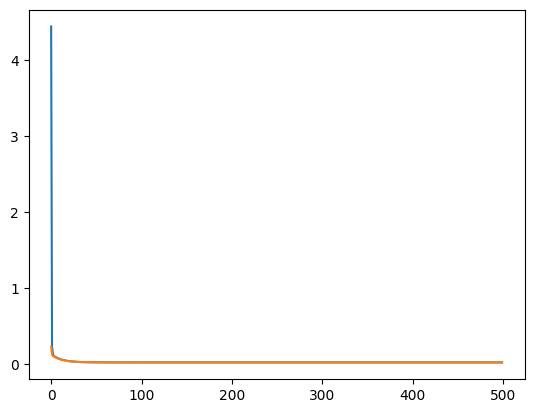

In [8]:
lc_tf = LinearClassifierTensorFlow(constant.n)
train_loss_tf, val_loss_tf = [], []
for epoch in range(constant.epoch):
    train_loss_tf.append(
        lc_tf.fit(dataset.train_samples, dataset.train_targets).numpy()
    )
    val_loss_tf.append(lc_tf.evaluate(dataset.val_samples, dataset.val_targets).numpy())

print("Train Loss — TF: ", train_loss_tf[-1])
print("Val Loss — TF: ", val_loss_tf[-1])
plt.plot(train_loss_tf)
plt.plot(val_loss_tf)

---
# **Linear Classifier — Keras V1**
---

**General**
- Layer encapsulates state (weight) and function (forward propagation)
- When implementing own layer, put the forward propagation in the call method

**Implementation**

In [9]:
class LinearClassifierKerasV1:
    def __init__(self, n):
        self.optimizer = tf.keras.optimizers.SGD(learning_rate=n)
        self.loss = tf.keras.losses.MeanSquaredError()
        self.w = tf.Variable(
            initial_value=tf.random.uniform(
                shape=(constant.input_dim, constant.output_dim)
            )
        )
        self.b = tf.Variable(initial_value=tf.zeros(shape=(constant.output_dim,)))
        self.n = n

    def fit(self, samples, targets):
        # ---------------------------------------
        # Forward Propagation
        # ---------------------------------------
        with tf.GradientTape() as tape:
            predict_targets = tf.matmul(samples, self.w) + self.b
            predict_loss = self.loss(targets, predict_targets)
        # ---------------------------------------
        # Backward Propagation
        # ---------------------------------------
        gradient = tape.gradient(predict_loss, [self.w, self.b])
        self.optimizer.apply_gradients(zip(gradient, [self.w, self.b]))
        return predict_loss

    def evaluate(self, samples, true_targets):
        targets = tf.matmul(samples, self.w) + self.b
        loss = self.loss(true_targets, targets)
        return loss

    def predict(self, samples):
        return tf.matmul(samples, self.w) + self.b

**Usage**

Train Loss — Kera V1:  0.024911445
Val Loss — Kera V1:  0.02379599


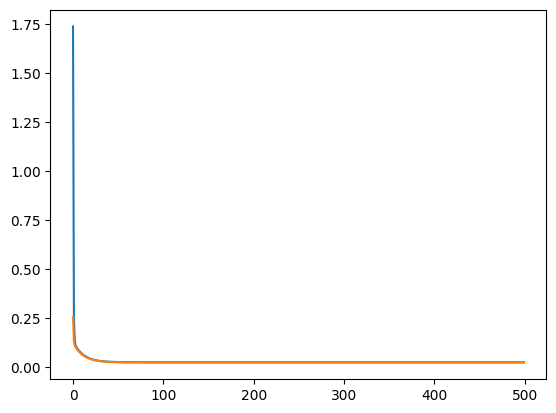

In [10]:
lc_keras_v1 = LinearClassifierKerasV1(constant.n)
train_loss_kera_v1, val_loss_kera_v1 = [], []
for epoch in range(constant.epoch):
    train_loss_kera_v1.append(
        lc_keras_v1.fit(dataset.train_samples, dataset.train_targets).numpy()
    )
    val_loss_kera_v1.append(
        lc_keras_v1.evaluate(dataset.val_samples, dataset.val_targets).numpy()
    )
print("Train Loss — Kera V1: ", train_loss_kera_v1[-1])
print("Val Loss — Kera V1: ", val_loss_kera_v1[-1])
plt.plot(train_loss_kera_v1)
plt.plot(val_loss_kera_v1)

---
# **Linear Classifier — Kera V2**
---

**Implementation**

In [11]:
class LinearClassifierKerasV2:
    def __init__(self, n):
        model = tf.keras.Sequential(tf.keras.layers.Dense(units=1, activation=None))
        model.compile(
            optimizer=tf.keras.optimizers.SGD(n),
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.BinaryAccuracy()],
        )
        self.model = model

    def fit(self, samples, targets):
        history = self.model.fit(
            x=samples,
            y=targets,
            epochs=constant.epoch,
            validation_data=(dataset.val_samples, dataset.val_targets),
            verbose=False,
        )
        return history.history

    def evaluate(self, samples, true_targets):
        return self.model.evaluate(x=samples, y=true_targets, verbose=False)

    def predict(self, samples):
        return self.model.predict(x=samples)

**Usage**

Train Loss — Keras V2:  0.027569901198148727
Val Loss — Keras V2:  0.03531459718942642


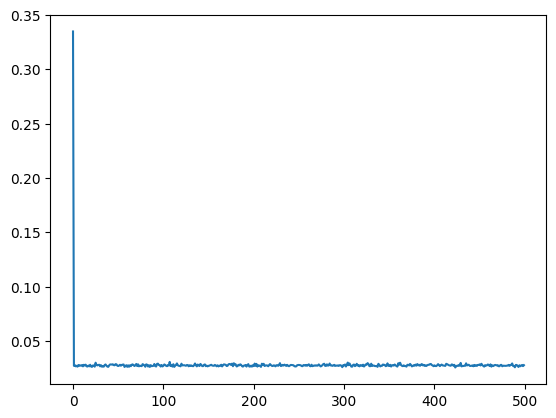

In [12]:
lc_keras_v2 = LinearClassifierKerasV2(constant.n)
train_loss_kera_v1 = lc_keras_v2.fit(dataset.train_samples, dataset.train_targets)[
    "loss"
]
val_loss_kera_v2 = lc_keras_v2.evaluate(dataset.val_samples, dataset.val_targets)[0]
print("Train Loss — Keras V2: ", train_loss_kera_v1[-1])
print("Val Loss — Keras V2: ", val_loss_kera_v2)
plt.plot(train_loss_kera_v1)

---